# Numerical Project in Python - Cooperative Kernel regression
## Ahmed Yassine Chraa - Emma de Charry - Pauline Zhou



## Part I - Class 1 & 2

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import utils


In [ ]:
with open('first_database.pkl', 'rb') as f: # Load data
    x,y = pickle.load(f)

In [24]:
# Parameters
n, m, a = 100, 10, 5
sigma2 = 0.25
nu = 1

# Generate data
x_n=x[:n] 
y_n=y[:n]

sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])

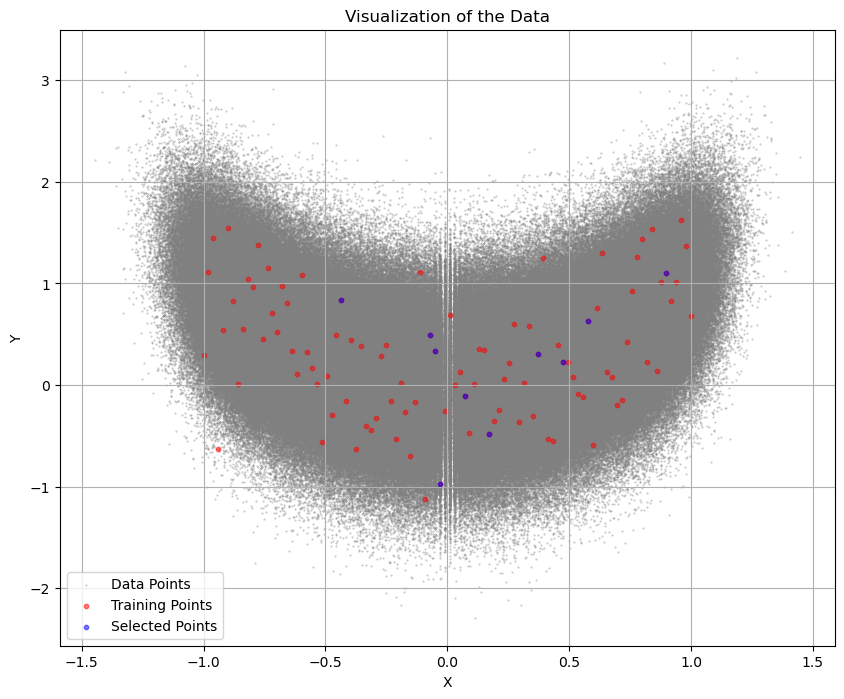

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='gray',s=0.2, alpha=0.5, label='Data Points')
plt.scatter(x_n, y_n, color='red',s=10, alpha=0.5, label='Training Points')
plt.scatter(x_selected, [y[i] for i in ind], color='blue',s=10, alpha=0.5, label='Selected Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization of the Data')
plt.legend()
plt.grid(True)
plt.show()

#### Useful functions that will be used along the notebook

In [22]:
def euclidean_kernel(x, xi):
    """
    Compute the Euclidean kernel between two vectors.
    """
    return np.exp(-np.linalg.norm(x - xi)**2)

def compute_alpha_star(Kmm, Knm, y, sigma2, nu):
    """
    Compute the alpha_star vector.
    """
    m = Kmm.shape[0]
    A = sigma2 * Kmm + Knm.T @ Knm + nu * np.eye(m)
    b = Knm.T @ y
    
    return np.linalg.solve(A, b)

def compute_kernel_matrix(X, Y):
    """
    Compute the kernel matrix between two sets of vectors.
    """
    rows, cols = X.shape[0], Y.shape[0]
    K = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            K[i, j] = euclidean_kernel(X[i], Y[j])
    
    return K

def local_objective_function(alpha, sigma2, K_mm, y_loc, K_im, nu, a):
    """
    Compute the local objective function value.
    """
    term1 = (sigma2 / (2 * a)) * alpha.T @ K_mm @ alpha
    term2 = 0.5 * np.sum((y_loc - K_im @ alpha) ** 2)
    term3 = (nu / (2 * a)) * np.linalg.norm(alpha) ** 2
    
    return term1 + term2 + term3

def compute_local_gradient(alpha, sigma2, K_mm, y_loc, K_im, nu, a):
    """
    Compute the local gradient.
    """
    grad = (sigma2 / a) * (K_mm @ alpha)
    grad += K_im.T @ (K_im @ alpha - y_loc)
    grad += (nu / a) * alpha
    
    return grad

def nystrom_approx(alpha, X_selected, X):
    """
    Compute the Nystrom approximation.
    """
    K1m = compute_kernel_matrix(X, X_selected)
    return K1m @ alpha


 ### Decentralized gradient descent

 We are first going to define the DGD function and then apply it.

In [42]:
def DGD(X, Y, X_selected, a, nu, sigma2, n_epochs, alpha_star, W, step_size):
    """
    Decentralized gradient descent algorithm with multiple agents.
    """
    m = X_selected.shape[0]
    n = X.shape[0]

    a_data_idx = np.array_split(np.random.permutation(n), a)
    W = np.kron(W, np.ones((m, m)))
    alpha = np.ones((m*a, 1))
    Kmm = compute_kernel_matrix(X_selected, X_selected)
    opt_gaps = [[] for _ in range(a)]
    alphas = []

   

    for epoch in range(n_epochs):
        print(epoch)
        alphas.append(alpha)
        gradients = np.zeros((m*a, 1))

        for a_idx, data_idx in enumerate(a_data_idx):
            X_local = X[data_idx]
            y_loc = Y[data_idx].reshape(-1, 1)
            Kim = compute_kernel_matrix(X_local, X_selected)
            local_gradient = compute_local_gradient(alpha[m * a_idx: m * (a_idx + 1)], sigma2, Kmm, y_loc, Kim, nu, a)
            gradients[m * a_idx: m * (a_idx + 1)] = local_gradient
        
        alpha = W @ alpha - step_size * gradients
        
        for a_idx in range(a):
            alpha_agent = alpha[m * a_idx: m * (a_idx + 1)].reshape(-1, 1)
            opt_gap = np.linalg.norm(alpha_agent - alpha_star.reshape(-1, 1))
            opt_gaps[a_idx].append(opt_gap)
        
     
        
    return opt_gaps, alphas


We then plot optimality gaps for each agent